
Step 1:
------
Preprocess the data. Selection/generation/ transformation of categorical variables, useful variables etc all your discretion.
-----


In [335]:
import os
import pandas as pd
os.getcwd()
os.chdir('/Users/Khristine/Documents/Masters/MSCA 31008 Data Mining/Assignment_3/Titanic Survival')

df=pd.read_csv("train.csv", index_col='PassengerId')
pd.set_option('display.max_columns', None)
df.head(6)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


Check how many missing values

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Check how many unique values

In [337]:
df.describe(include='all').loc['unique', :]

Survived    NaN
Pclass      NaN
Name        891
Sex           2
Age         NaN
SibSp       NaN
Parch       NaN
Ticket      681
Fare        NaN
Cabin       147
Embarked      3
Name: unique, dtype: object

In [338]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

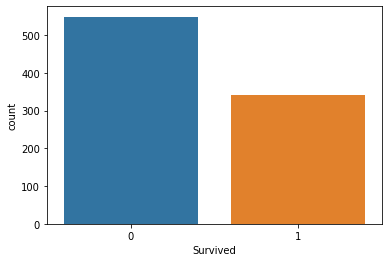

In [339]:
df_sur = df.dropna(subset=['Survived'])


import matplotlib.pyplot as plt
from numpy import array 
import seaborn as sns



sns.countplot(x="Survived", data=df_sur)

Clean data
---

In [340]:
#create new dataset for modified data
new_df=df

#columns to review
['Survived',
 'Pclass', -- DONE, this column looks good, no null values
 'Name', --DONE, removed
 'Sex', --DONE, dummy variables
 'Age', --DONE, imputed data using kmeans
 'SibSp', --DONE, combined iwth Parch, assgiend values greater than 0 to their own bin
 'Parch', --DONE, see above
 'Ticket', --DONE, removed
 'Fare', --DONE, no changes made
 'Cabin', --DONE, removed
 'Embarked'] --DONE, filled in most common values as there are only 3 missing values

In [341]:
df['Survived'].isna().sum() #check to see if survived has null values

0

Fill in age using kmeans clustering

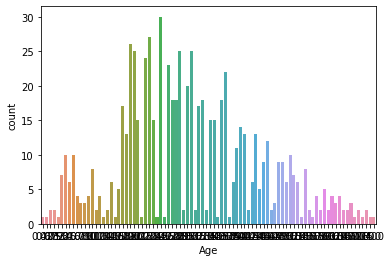

In [342]:
df_age = df.dropna(subset=['Age'])


import matplotlib.pyplot as plt
from numpy import array 
import seaborn as sns


#take a look at what the distribution looks like
sns.countplot(x="Age", data=df_age)

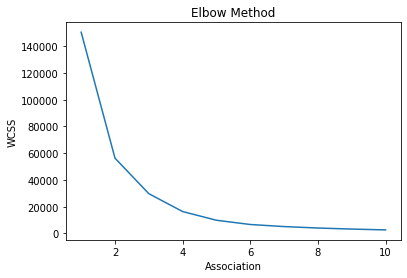

In [343]:
x = df_age.iloc[:, [4]].values #set x to age value

#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

#looks like plot drops around 4

In [344]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [345]:
age = df.iloc[:, [4]]

labels, centroids, X_hat = kmeans_missing(age, n_clusters=5)
new_df['Age']=X_hat

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [346]:
#check if the values are filled in correctly

print (df['Age'].isna().sum())
print (new_df['Age'].isna().sum()) #now the results show 0 na's :) 

0
0


Embarked column

In [347]:
#new=df["Embarked"].fillna("S", inplace = True)
new_df['Embarked']=df['Embarked'].fillna('S') #fill in with most dominant port
print (new_df['Embarked'].isna().sum()) #check that results whos 0 nulls

0


Combine Sibling and Parch column

In [348]:
df['SP_Comb']=df['Parch']+df['SibSp']

In [349]:
df['SP_Comb'].value_counts() #most people are 0, convert to binary column

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: SP_Comb, dtype: int64

In [350]:
#assign values greater than 0 to their own bin
a = np.array(df['SP_Comb'].values.tolist())
new_df['SP_Comb'] = np.where(a >=1, 1, a).tolist()

In [351]:
#check for unique values
new_df['SP_Comb'].value_counts()

0    537
1    354
Name: SP_Comb, dtype: int64

Class column

In [352]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Cabin column

In [353]:
df['Cabin'].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F33            3
D              3
C22 C26        3
E101           3
F2             3
E24            2
D36            2
C126           2
C68            2
B28            2
D17            2
B20            2
B18            2
B58 B60        2
C124           2
D26            2
C65            2
E33            2
C83            2
E8             2
E67            2
D35            2
C123           2
D20            2
B22            2
C125           2
B51 B53 B55    2
              ..
D50            1
B82 B84        1
C47            1
A20            1
E40            1
B30            1
D7             1
A23            1
D37            1
C85            1
B73            1
D47            1
B4             1
D56            1
D15            1
A32            1
C30            1
D49            1
C32            1
C101           1
A7             1
D45            1
A10            1
C148           1
E10            1
E46            1
C70            1
D10 D12       

In [354]:
df['Cabin'].fillna(value = 'N', inplace=True)
new_df['Cabin']=df['Cabin'].apply(lambda x: x[0])

In [355]:
new_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

Dropping columnes Name, ticket, cabin, parch

In [356]:
#remove this columns
new_df.drop(['Name'], axis=1, inplace=True)
new_df.drop(['Ticket'], axis=1, inplace=True)
#new_df.drop(['Cabin'], axis=1, inplace=True)
new_df.drop(['Parch'], axis=1, inplace=True)

In [357]:
new_df.info() #ByEEEE

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Fare        891 non-null float64
Cabin       891 non-null object
Embarked    891 non-null object
SP_Comb     891 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 69.6+ KB


Fare column

In [358]:
new_df['Fare'].isna().sum() #looks ok

0

Create dummy columns for sex and embarked

In [359]:
#df_obj = df.select_dtypes(['object'])
#df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip('%$'))

new_df=pd.get_dummies(df, columns=["Sex"])
new_df=pd.get_dummies(new_df, columns=["Embarked"])
new_df=pd.get_dummies(new_df, columns=["Cabin"])



In [360]:
new_df.head(7)

,Survived,Pclass,Age,SibSp,Fare,SP_Comb,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,22.00000,1,7.2500,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2,1,1,38.00000,1,71.2833,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3,1,3,26.00000,0,7.9250,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,1,35.00000,1,53.1000,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
5,0,3,35.00000,0,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
6,0,3,30.80155,0,8.4583,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
7,0,1,54.00000,0,51.8625,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


Step 2:
-----

Build your models: Please build classification models in Python to predict the Survived binary status assigned to a passenger. When writing the code associated with each model, please have the first part produce and save the model, followed by a second part that loads and applies the model.
------


In [361]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import sklearn.model_selection as cv
list(new_df)

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Fare',
 'SP_Comb',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_N',
 'Cabin_T']

In [362]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

y=new_df['Survived']
cols=[
 'Pclass',
 'Age',
 'SibSp',
 'Fare',
 'SP_Comb',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_N',
 'Cabin_T']
x=new_df[cols]
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=0.2)
SEED=1

Decision tree -- CV accuracy = 0.80 
use accuracy for classification, this is not a regression

In [363]:
#Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=9, random_state=1)
#dt = DecisionTreeClassifier(random_state = 40)
# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [364]:
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = dt.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


Test set accuracy: 0.81


In [365]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(dt, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.78 (+/- 0.06)
[-0.79020979 -0.76223776 -0.73239437 -0.82394366 -0.76760563]


#hyperparameter tuning --setting to markdown, taking too long to run
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13],
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
             'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             'random_state':[1]
}

CV_rfc = GridSearchCV(estimator=dt, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

In [366]:
#Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_features= 'auto',
                            max_depth=9,
                            min_samples_leaf= 1,
                            min_samples_split= 13,
                            random_state=1)
#dt = DecisionTreeClassifier(random_state = 40)
# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [367]:
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = dt.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))



Test set accuracy: 0.79


In [368]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(dt, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.80 (+/- 0.01)
[-0.7972028  -0.8041958  -0.8028169  -0.79577465 -0.78873239]


SVM -- CV accuracy = 0.67

In [369]:
from sklearn.svm import SVC

svm = SVC(C=0.5, kernel='rbf')
svm.fit(x_train, y_train)

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [370]:
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = svm.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


Test set accuracy: 0.63


In [371]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(svm, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.71 (+/- 0.07)
[-0.69444444 -0.72222222 -0.75       -0.70833333 -0.75       -0.64788732
 -0.70422535 -0.74285714 -0.75714286 -0.67142857]


#hyperparameter tuning -- tried to do but took too long to process
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
preproc_x = preprocessing.scale(x) 
(x_train_p, x_test_p, y_train, y_test) = cv.train_test_split(preproc_x, y, test_size=0.2)


param_grid = { 
    'C': [0.1, 1, 10,100], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [ 1, 0.1, 0.001, 0.0001]}
CV_rfc = GridSearchCV(estimator=svm, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train_p, y_train)


CV_rfc.best_params_

In [372]:
svm = SVC(C=0.5, kernel='rbf')
svm.fit(x_train, y_train)


# Predict test set labels
y_pred = svm.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


Test set accuracy: 0.63


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [373]:
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

X = preprocessing.scale(x) 


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(svm, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.71 (+/- 0.07)
[-0.69444444 -0.72222222 -0.75       -0.70833333 -0.75       -0.64788732
 -0.70422535 -0.74285714 -0.75714286 -0.67142857]


Logistic Regression --CV accuracy =.81

In [374]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=1)

# Fit dt to the training set
lg.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [375]:
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = lg.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


Test set accuracy: 0.80


In [376]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(lg, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.80 (+/- 0.08)
[-0.83333333 -0.81944444 -0.86111111 -0.83333333 -0.81944444 -0.71830986
 -0.76056338 -0.78571429 -0.82857143 -0.78571429]


Random Forest -- CV accuracy= 0.82 
Looks like this is performing the best so far

In [377]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


Test set accuracy: 0.81


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [378]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.80 (+/- 0.06)
[-0.76388889 -0.80555556 -0.75       -0.79166667 -0.84722222 -0.76056338
 -0.78873239 -0.84285714 -0.81428571 -0.8       ]


Voting classifier -- CV accurace =0.82

In [379]:
# Import function to compute accuracy
from sklearn.metrics import accuracy_score
import pandas as pd
# Import function to split data
from sklearn.model_selection import train_test_split
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
# Import the VotingClassifier meta-model
from sklearn.ensemble import VotingClassifier
# Set seed for reproducibility

In [380]:

# Split data into 70% train and 30% test
#X_train, X_test, y_train, y_test = train_test_split(x, y,
#test_size= 0.2,
#random_state= SEED)
# Instantiate individual classifiers
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(n_estimators = 100,random_state=SEED)


# Define a list called classifier that contains
# the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rf)]

In [381]:
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set
vc.fit(x_train, y_train)
# Predict test set labels
y_pred = vc.predict(x_test)
# Evaluate the test-set accuracy of 'vc'


accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Voting Classifier: 0.832


In [382]:
# Import VotingCLassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers, voting='hard')     

# Fit vc to the training set
vc.fit(x_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(x_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Hard Voting Classifier: {:.3f}'.format(accuracy))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Hard Voting Classifier: 0.832


In [383]:
# Import VotingCLassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers, voting='soft')     

# Fit vc to the training set
vc.fit(x_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(x_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Soft Voting Classifier: {:.3f}'.format(accuracy))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Soft Voting Classifier: 0.816


In [384]:
# Import accuracy_score
from sklearn.metrics import accuracy_score
for clf_name, clf in classifiers:    
  
    # Fit clf to the training set
    clf.fit(x_train, y_train)    
  
    # Predict y_pred
    y_pred = clf.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
  
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.804
K Nearest Neighbours : 0.721
Classification Tree : 0.799


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Random Forest : 0.810


In [385]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(vc, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.82 (+/- 0.08)
[-0.79166667 -0.80555556 -0.86111111 -0.86111111 -0.83333333 -0.73239437
 -0.8028169  -0.84285714 -0.85714286 -0.84285714]


Seems like voting and rf were the best, going to tune these to see if I can make them better

from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 12,50,100,150,200,250],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 50}

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

In [386]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion= 'gini',
 max_depth= 8,
 max_features= 'auto',
 n_estimators= 100, random_state=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

Test set accuracy: 0.85


In [387]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = cross_val_score(rf, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: 0.82 (+/- 0.02)
[0.83916084 0.81818182 0.81690141 0.8028169  0.82394366]


Trying to tune voting classifier

In [388]:
SEED=1
lr = LogisticRegression(random_state=SEED)
knn = KNN()
svm= SVC(C=0.5, kernel='rbf')
dt = dt = DecisionTreeClassifier(max_features= 'auto',
                            max_depth=9,
                            min_samples_leaf= 1,
                            min_samples_split= 13,
                            random_state=1)

rf = RandomForestClassifier(criterion= 'gini',
 max_depth= 8,
 max_features= 'auto',
 n_estimators= 100, random_state=1)

#svm = SVC(C=0.5, kernel='rbf')

# Define a list called classifier that contains
# the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rf)]
# ,
#'SVC', svm)]

vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set
vc.fit(x_train, y_train)
# Predict test set labels
y_pred = vc.predict(x_test)
# Evaluate the test-set accuracy of 'vc'


accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.838


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Tried to add svm but the accuracy was fine without it. accuracy =0.844 here. Going to go with the prior one
SEED=1
lr = LogisticRegression(random_state=SEED)
knn = KNN()
svm= SVC(C=0.5, kernel='rbf')
dt = dt = DecisionTreeClassifier(max_features= 'auto',
                            max_depth=9,
                            min_samples_leaf= 1,
                            min_samples_split= 13,
                            random_state=1)

rf = RandomForestClassifier(criterion= 'gini',
 max_depth= 8,
 max_features= 'auto',
 n_estimators= 100, random_state=1)

svm = SVC(C=0.5, kernel='rbf')

Define a list called classifier that contains
the tuples (classifier_name, classifier)
classifiers = [
    ('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rf),
('SVC', svm)]

vc = VotingClassifier(estimators=classifiers)
Fit 'vc' to the traing set
vc.fit(x_train, y_train)
Predict test set labels
y_pred = vc.predict(x_test)
Evaluate the test-set accuracy of 'vc'


accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))


Hard voting classifier

In [389]:
# Import VotingCLassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers, voting='hard')     

# Fit vc to the training set
vc.fit(x_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(x_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Hard Voting Classifier: {:.3f}'.format(accuracy))

Hard Voting Classifier: 0.838


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [390]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = cross_val_score(vc, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: 0.81 (+/- 0.03)
[0.83916084 0.8041958  0.81690141 0.8028169  0.8028169 ]


Soft voting classifier

In [391]:
# Import VotingCLassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers, voting='soft')     

# Fit vc to the training set
vc.fit(x_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(x_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Soft Voting Classifier: {:.3f}'.format(accuracy))

Soft Voting Classifier: 0.849


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Bagging with RF

In [392]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [393]:

bagg = BaggingClassifier(base_estimator = rf, verbose = 0, n_jobs = -1, random_state = 1)

bagg.fit(x_train, y_train)
y_pred = bagg.predict(x_test)# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

Test set accuracy: 0.83


In [394]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = cross_val_score(bagg, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: 0.81 (+/- 0.03)
[0.7972028  0.81818182 0.82394366 0.79577465 0.83802817]


Bagging with DT

In [395]:
# Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(max_features= 'auto',
                            max_depth=9,
                            min_samples_leaf= 1,
                            min_samples_split= 13,
                            random_state=1)
# Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(base_estimator=dt, n_estimators=300,
n_jobs=-1)
# Fit 'bc' to the training set
bc.fit(x_train, y_train)
# Predict test set labels
y_pred = bc.predict(x_test)
# Evaluate and print test-set accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))



Accuracy of Bagging Classifier: 0.816


In [396]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(bc, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.81 (+/- 0.03)
[-0.7972028  -0.82517483 -0.8028169  -0.8028169  -0.83098592]


ADA Boosting

In [397]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
abc.fit(x_train, y_train)
# Predict test set labels
y_pred = abc.predict(x_test)
# Evaluate and print test-set accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))



Accuracy of Bagging Classifier: 0.804


In [398]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(abc, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

Accuracy: -0.79 (+/- 0.04)
[-0.78321678 -0.81818182 -0.78873239 -0.76760563 -0.76760563]


After the testing, looks like Random Forest is performing best. I'll use this one to predict the test set

In [399]:
from sklearn.ensemble import RandomForestClassifier

final_rf = RandomForestClassifier(criterion= 'gini',
 max_depth= 8,
 max_features= 'auto',
 n_estimators= 100, random_state=1)
final_rf.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Step 3
--------
Test your models using the data found within the "Holdout_testing" file. Save the results of the final model (remember you will only predict the Survived column in holdout test set with your best model results) in a single, separate CSV titled "Titanic Results from" *insert your name or UChicago net ID.

In [411]:
import os
import pandas as pd
os.getcwd()
os.chdir('/Users/Khristine/Documents/Masters/MSCA 31008 Data Mining/Assignment_3/Titanic Survival')

train_df=pd.read_csv("holdout_test.csv")
                     #, index_col='PassengerId')
pd.set_option('display.max_columns', None)
train_df.head(6)

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,NaN,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S


Check how many missing values

In [412]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Survived       0 non-null float64
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 39.3+ KB


Check how many unique values

In [413]:
train_df.describe(include='all').loc['unique', :]

Survived       NaN
PassengerId    NaN
Pclass         NaN
Name           418
Sex              2
Age            NaN
SibSp          NaN
Parch          NaN
Ticket         363
Fare           NaN
Cabin           76
Embarked         3
Name: unique, dtype: object

look like theres a null value in fare

In [414]:
train_df=train_df.fillna(train_df.median())

In [415]:
train_df_sur = train_df.dropna(subset=['Survived'])
train_df.isnull().sum()

Survived       418
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

Clean data
---

In [416]:
#create new dataset for modified data
train_new_df=train_df

#columns to review
['Survived',
 'Pclass', -- DONE, this column looks good, no null values
 'Name', --DONE, removed
 'Sex', --DONE, dummy variables
 'Age', --DONE, imputed data using kmeans
 'SibSp', --DONE, combined iwth Parch, assgiend values greater than 0 to their own bin
 'Parch', --DONE, see above
 'Ticket', --DONE, removed
 'Fare', --DONE, no changes made
 'Cabin', --DONE, removed
 'Embarked'] --DONE, filled in most common values as there are only 3 missing values

In [417]:
train_df['Survived'].isna().sum() #check to see if survived has null values

418

Fill in age using kmeans clustering

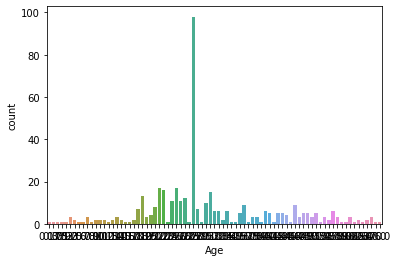

In [418]:
train_df_age = train_df.dropna(subset=['Age'])


import matplotlib.pyplot as plt
from numpy import array 
import seaborn as sns


#take a look at what the distribution looks like
sns.countplot(x="Age", data=train_df_age)

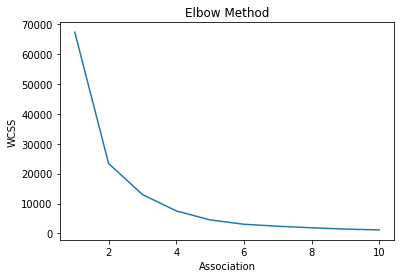

In [419]:
train_x = train_df_age.iloc[:, [5]].values #set x to age value

#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(train_x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

#looks like plot drops around 4

In [420]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [421]:
train_age = train_df.iloc[:, [5]]

labels, centroids, X_hat = kmeans_missing(train_age, n_clusters=5)
train_new_df['Age']=X_hat

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [422]:
#check if the values are filled in correctly

print (train_df['Age'].isna().sum())
print (train_new_df['Age'].isna().sum()) #now the results show 0 na's :) 

0
0


Embarked column

In [423]:
#new=df["Embarked"].fillna("S", inplace = True)
train_new_df['Embarked']=train_df['Embarked'].fillna('S') #fill in with most dominant port
print (train_new_df['Embarked'].isna().sum()) #check that results whos 0 nulls

0


Combine Sibling and Parch column

In [424]:
train_df['SP_Comb']=train_df['Parch']+train_df['SibSp']

In [425]:
train_df['SP_Comb'].value_counts() #most people are 0, convert to binary column

0     253
1      74
2      57
3      14
4       7
10      4
6       4
5       3
7       2
Name: SP_Comb, dtype: int64

In [426]:
#assign values greater than 0 to their own bin
train_a = np.array(train_df['SP_Comb'].values.tolist())
train_new_df['SP_Comb'] = np.where(train_a >=1, 1, train_a).tolist()

In [427]:
#check for unique values
train_new_df['SP_Comb'].value_counts()

0    253
1    165
Name: SP_Comb, dtype: int64

Class column

In [428]:
train_df['Pclass'].value_counts()

3    218
1    107
2     93
Name: Pclass, dtype: int64

Cabin column

In [429]:
train_df['Cabin'].value_counts()

B57 B59 B63 B66    3
F4                 2
C80                2
C89                2
A34                2
E34                2
C55 C57            2
B45                2
C6                 2
C101               2
C23 C25 C27        2
C31                2
C116               2
C78                2
D21                1
C32                1
B24                1
D19                1
C132               1
B51 B53 B55        1
B58 B60            1
B71                1
A29                1
F2                 1
D43                1
C97                1
F E57              1
C105               1
D15                1
B26                1
                  ..
D10 D12            1
A9                 1
D22                1
E31                1
E60                1
D28                1
C53                1
B69                1
C39                1
G6                 1
D40                1
C130               1
E50                1
F G63              1
B41                1
C28                1
F E46        

In [430]:
train_df['Cabin'].fillna(value = 'N', inplace=True)
train_new_df['Cabin']=train_df['Cabin'].apply(lambda x: x[0])

In [431]:
train_new_df['Cabin'].value_counts()

N    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

Dropping columnes Name, ticket, cabin, parch

In [432]:
#remove this columns
train_new_df.drop(['Name'], axis=1, inplace=True)
train_new_df.drop(['Ticket'], axis=1, inplace=True)
#train_new_df.drop(['Cabin'], axis=1, inplace=True)
train_new_df.drop(['Parch'], axis=1, inplace=True)

In [433]:
train_new_df.info() #ByEEEE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Survived       0 non-null float64
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
SP_Comb        418 non-null int64
dtypes: float64(3), int64(4), object(3)
memory usage: 32.7+ KB


Fare column

In [434]:
train_new_df['Fare'].isna().sum() #looks ok

0

Create dummy columns for sex and embarked

In [435]:
#df_obj = df.select_dtypes(['object'])
#df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip('%$'))

train_new_df=pd.get_dummies(train_df, columns=["Sex"])
train_new_df=pd.get_dummies(train_new_df, columns=["Embarked"])
train_new_df=pd.get_dummies(train_new_df, columns=["Cabin"])



In [436]:
list(train_new_df) #Looks like it's missing a Cabin_T columns

['Survived',
 'PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Fare',
 'SP_Comb',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_N']

In [437]:
train_new_df['Cabin_T']=0

In [438]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#y=new_df['Survived']
cols=[ 'Pclass',
 'Age',
 'SibSp',
 'Fare',
 'SP_Comb',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_N',
 'Cabin_T']
x=train_new_df[cols]
SEED=1

In [439]:

y_pred = final_rf.predict(x)

In [440]:
np.bincount(y_pred) #distribution looks similar to the testing dataset

array([280, 138])

In [441]:
train_df=pd.read_csv("holdout_test.csv")

submission = pd.DataFrame({
        "PassengerId": train_new_df["PassengerId"],
        "Survived": final_rf.predict(x)})
submission.to_csv('submission_rf.csv', index = False)

I used decision tree, random forest, svm, voting classifier, bagging
Decision Tree
-Pros: Don't need as much preprocessing, easy to explain
-Cons: Prone to overfit on irrelevant classifiers

Random Forest
-Pros: Takes random groups of features so less likely to overkill on an irrelevant feature, generally performs well 
-Cons: Prone to overfit an individual tree

SVM
-Pros: Can handle non-linear bounds
-Cons: Memory intensive, took awhile to run 

Voting Classifier
-Pros: Learn from many models, can learn from the weak classifiers
-Cons: all models have the same voting power


Logistic regression
-Pros: Regression problem with easier interpretation
-Cons: Tends to not work well if data is non-linear
